## JPL Horizons

In [2]:

from astroquery.jplhorizons import Horizons
from astropy.time import Time


## The main package we're using is [JPL Horizons](https://ssd.jpl.nasa.gov/horizons.cgi).


#### Nasa Id - 0 is barycenter of the solar system (we should define barycenter somewhere) 
-> 1 is Mercury -> 2 is Venus -> 3 is Earth -> 4 is Mars -> 5 is Jupiter -> 6 is Saturn -> 7 is Uranus -> 8 is Neptune -> 9 is Pluto

I haven't found a list of these yet in documentation but it would be helpful to have.

In [3]:
sim_start_date = "2018-01-01"     # simulating a solar system starting from this date
time = Time(sim_start_date).jd
nasaid = 3 # Earth

mercury = Horizons(id=nasaid, location="@sun", epochs=time).vectors() # fetches the vectors 
type(mercury)
mercury.keys()

['targetname',
 'datetime_jd',
 'datetime_str',
 'x',
 'y',
 'z',
 'vx',
 'vy',
 'vz',
 'lighttime',
 'range',
 'range_rate']


Venus = Horizons(id=2, location="@sun", epochs=time).ephemerides() #ephemerides is a bunch of other data we can fetch
Venus


### The fetched vectors are returned in an [astropy table](https://docs.astropy.org/en/stable/table/index.html)

In [5]:

# access table values
print('mercurys x value: ', mercury['x'])
print('mercurys y value: ', mercury['y'])
print('mercurys z value: ', mercury['z'])
type(mercury['x'])

mercurys x value:           x         
         AU        
-------------------
-0.3877081976897142
mercurys y value:            y          
          AU         
---------------------
-0.007784734354832311
mercurys z value:           z         
         AU        
-------------------
0.03493213520287913


astropy.table.column.MaskedColumn

/var/folders/wg/ttcg22kd7hn775xrvbj5blmm0000gn/T/ipykernel_33091/440659459.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.r    = np.array(r, dtype=np.float)
/var/folders/wg/ttcg22kd7hn775xrvbj5blmm0000gn/T/ipykernel_33091/440659459.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.v    = np.array(v, dtype=np.float)


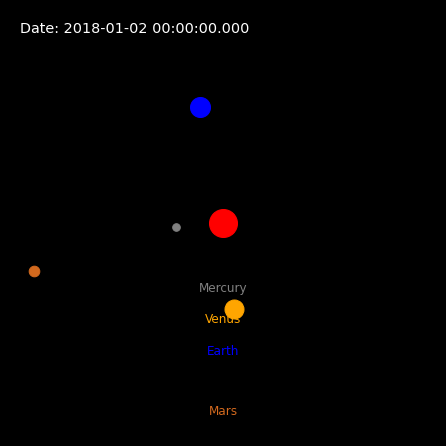

In [36]:
#Code from https://medium.com/analytics-vidhya/simulating-the-solar-system-with-under-100-lines-of-python-code-5c53b3039fc6

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.time import Time
from astroquery.jplhorizons import Horizons

sim_start_date = "2018-01-01"     # simulating a solar system starting from this date
sim_duration = 2 * 365                # (int) simulation duration in days
m_earth = 5.9722e24 / 1.98847e30  # Mass of Earth relative to mass of the sun
m_moon = 7.3477e22 / 1.98847e30
 
class Object:                   # define the objects: the Sun, Earth, Mercury, etc
    def __init__(self, name, rad, color, r, v):
        self.name = name
        self.r    = np.array(r, dtype=np.float)
        self.v    = np.array(v, dtype=np.float)
        self.xs = []
        self.ys = []
        self.plot = ax.scatter(r[0], r[1], color=color, s=rad**2, edgecolors=None, zorder=10)
        self.line, = ax.plot([], [], color=color, linewidth=1.4)

class SolarSystem:
    def __init__(self, thesun):
        self.thesun = thesun
        self.planets = []
        self.time = None
        self.timestamp = ax.text(.03, .94, 'Date: ', color='w', transform=ax.transAxes, fontsize='x-large')
    def add_planet(self, planet):
        self.planets.append(planet)
    def evolve(self):           # evolve the trajectories
        dt = 1.0
        self.time += dt
        plots = []
        lines = []
        for p in self.planets:
            p.r += p.v * dt
            acc = -2.959e-4 * p.r / np.sum(p.r**2)**(3./2)  # in units of AU/day^2
            p.v += acc * dt
            p.xs.append(p.r[0])
            p.ys.append(p.r[1])
            p.plot.set_offsets(p.r[:2])
            p.line.set_xdata(p.xs)
            p.line.set_ydata(p.ys)
            plots.append(p.plot)
            lines.append(p.line)
        self.timestamp.set_text('Date: ' + Time(self.time, format='jd', out_subfmt='float').iso)
        return plots + lines + [self.timestamp]

plt.style.use('dark_background')
fig = plt.figure(figsize=[6, 6])
ax = plt.axes([0., 0., 1., 1.], xlim=(-1.8, 1.8), ylim=(-1.8, 1.8))
ax.set_aspect('equal')
ax.axis('off')
ss = SolarSystem(Object("Sun", 28, 'red', [0, 0, 0], [0, 0, 0]))
ss.time = Time(sim_start_date).jd
colors = ['gray', 'orange', 'blue', 'chocolate']
sizes = [0.38, 0.95, 1., 0.53]
names = ['Mercury', 'Venus', 'Earth', 'Mars']
texty = [.47, .73, 1, 1.5]
for i, nasaid in enumerate([1, 2, 3, 4]):  # The 1st, 2nd, 3rd, 4th planet in solar system
    obj = Horizons(id=nasaid, location="@sun", epochs=ss.time, id_type='id').vectors()
    ss.add_planet(Object(nasaid, 20 * sizes[i], colors[i], 
                         [np.double(obj[xi]) for xi in ['x', 'y', 'z']], 
                         [np.double(obj[vxi]) for vxi in ['vx', 'vy', 'vz']]))
    ax.text(0, - (texty[i] + 0.1), names[i], color=colors[i], zorder=1000, ha='center', fontsize='large')
def animate(i):
    return ss.evolve()
ani = animation.FuncAnimation(fig, animate, repeat=False, frames=sim_duration, blit=True, interval=20,)
plt.show()
# ani.save('solar_system_6in_150dpi.mp4', fps=60, dpi=150)

In [1]:
3./2

1.5

In [38]:
#  np.sum(p.r)

## Acceleration Equation!


![accelerationEq](imgs/accelerationEquation.jpg)


This equation is derived from Newtons law of gravity and Newtons second law of motion.

Starting with Newtons law of gravity:

### g = G * M / r^2

Now the force equation 
### f = ma

By solving for acceleration we get 
### a = f/m

Now plug in the gravity equation for the force
### a = GM/r^2

Now we need to account that this acceleration is applied as a vector. 
For this we need the unit vector of the position

### unit vector = r / |r| 

Tack this onto the acceleration equation and we get

# a = GM/r^2 * r / |r|





In [37]:
p = ss.planets[0]
# print(np.sum(p.r))
print(p.r)
print(p.r[2])
# p.r[2] = 0


acc = -2.959e-4 * p.r / np.sum(p.r**2)**(3./2)  # in units of AU/day^2


#F = M/r^2
#A = F/M





print(acc)
# print(acc)
# print('acc: ', acc)
# print('p.r: ', p.r)
# print(np.sum(p.r))
# print(p.name, np.sum(p.r))

[-0.39299652 -0.0347043   0.03321761]
0.03321760673108579
[ 0.00187372  0.00016546 -0.00015837]


# Testing

We need to test the accuracy of the equations. We can do this by
* Run the simulation for a year and then print the values of the location and velocity vectors
* Fetch from the Horizons API the location and velocity vectors for the same time
* Compare the two vectors

How accurate is the simulation?